# Ensemble-based models to predict tissue

**Can we predict the tissue of origin of a sample from it's gene expression data?**

- AdaBoost - tends to overfit
- Bagging ensemble of ridge classifiers

author: @emilyekstrum
<br> 12/11/25

In [11]:
# load in modules
import numpy as np
import pandas as pd
import gzip
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# load latent spaces
latent_spaces = np.load('gtex_latent_spaces.npz')
pca_result_2d = latent_spaces['pca_2d']
pca_result_85 = latent_spaces['pca_hd']
umap_result_2d = latent_spaces['umap_from_2d']
umap_result_hd = latent_spaces['umap_from_hd']

print(f"Latent space shapes:")
print(f"PCA 2D: {pca_result_2d.shape}")
print(f"PCA high-D: {pca_result_85.shape}") # PCA that retained 85% variance
print(f"UMAP from 2D: {umap_result_2d.shape}")
print(f"UMAP from high-D: {umap_result_hd.shape}")

Latent space shapes:
PCA 2D: (12289, 2)
PCA high-D: (12289, 83)
UMAP from 2D: (12289, 2)
UMAP from high-D: (12289, 2)


In [13]:
# open merged dataframe to get tissue labels
with gzip.open('GTEx_merged_processed_data.csv.gz', 'rt') as f:
    merged_df = pd.read_csv(f)

# extract tissue labels
tissue_labels = merged_df['SMTS'].values
print(f"Number of samples: {len(tissue_labels)}")
print(f"Number of unique tissues: {len(np.unique(tissue_labels))}")
print(f"Tissue types: {np.unique(tissue_labels)}")

Number of samples: 12289
Number of unique tissues: 27
Tissue types: ['Adipose Tissue' 'Adrenal Gland' 'Blood' 'Blood Vessel' 'Brain' 'Breast'
 'Colon' 'Esophagus' 'Heart' 'Kidney' 'Liver' 'Lung' 'Muscle' 'Nerve'
 'Ovary' 'Pancreas' 'Pituitary' 'Prostate' 'Salivary Gland' 'Skin'
 'Small Intestine' 'Spleen' 'Stomach' 'Testis' 'Thyroid' 'Uterus' 'Vagina']


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_74229/4003594004.py:3: DtypeWarning: Columns (5008) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(f)


### Fit ensemble models to predict tissue

In [14]:
# AdaBoost to predict tissue type from latent spaces

# latent spaces dictionary
latent_spaces_dict = {
    'PCA_2D': pca_result_2d,
    'PCA_HighD': pca_result_85,
    'UMAP_from_2D': umap_result_2d,
    'UMAP_from_HighD': umap_result_hd
}

# store results
adaboost_results = {}

for space_name, X_data in latent_spaces_dict.items():
    print(f"\nTraining AdaBoost on {space_name}")
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, tissue_labels, test_size=0.2, random_state=42, stratify=tissue_labels
    )
    
    # fit AdaBoost classifier
    adaboost_model = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        random_state=42
    )
    
    adaboost_model.fit(X_train, y_train)
    
    # predictions
    y_pred = adaboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # store results
    adaboost_results[space_name] = {
        'model': adaboost_model,
        'accuracy': accuracy,
        'y_test': y_test,
        'y_pred': y_pred
    }

print("\nAdaBoost Results Summary:")
for space_name, results in adaboost_results.items():
    print(f"{space_name}: {results['accuracy']:.4f}")


Training AdaBoost on PCA_2D
Test Accuracy: 0.4369

Training AdaBoost on PCA_HighD
Test Accuracy: 0.6123

Training AdaBoost on UMAP_from_2D
Test Accuracy: 0.4402

Training AdaBoost on UMAP_from_HighD
Test Accuracy: 0.5090

AdaBoost Results Summary:
PCA_2D: 0.4369
PCA_HighD: 0.6123
UMAP_from_2D: 0.4402
UMAP_from_HighD: 0.5090


In [15]:
# bagging ensemble of ridge classifiers

# store bagging results
bagging_results = {}

for space_name, X_data in latent_spaces_dict.items():
    
    print(f"\nTraining Bagging Ridge Classifier on {space_name}")
    # train-test split 
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, tissue_labels, test_size=0.2, random_state=42, stratify=tissue_labels
    )
    
    # bagging ensemble of ridge classifiers
    ridge_bagging = BaggingClassifier(
        estimator=RidgeClassifier(alpha=1.0),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    )
    
    ridge_bagging.fit(X_train, y_train)
    
    # predictions
    y_pred = ridge_bagging.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # store results
    bagging_results[space_name] = {
        'model': ridge_bagging,
        'accuracy': accuracy,
        'y_test': y_test,
        'y_pred': y_pred
    }

print("\nBagging Ridge Results Summary:")
for space_name, results in bagging_results.items():
    print(f"{space_name}: {results['accuracy']:.4f}")


Training Bagging Ridge Classifier on PCA_2D
Test Accuracy: 0.3621

Training Bagging Ridge Classifier on PCA_HighD
Test Accuracy: 0.9638

Training Bagging Ridge Classifier on UMAP_from_2D
Test Accuracy: 0.3312

Training Bagging Ridge Classifier on UMAP_from_HighD
Test Accuracy: 0.4162

Bagging Ridge Results Summary:
PCA_2D: 0.3621
PCA_HighD: 0.9638
UMAP_from_2D: 0.3312
UMAP_from_HighD: 0.4162


### Model evaluation 

In [16]:
# compare model performances

spaces = list(adaboost_results.keys())
print("\nAccuracy by latent space:")
for space in spaces:
    ab_acc = adaboost_results[space]['accuracy']
    bg_acc = bagging_results[space]['accuracy']
    print(f"{space:15} - AdaBoost: {ab_acc:.4f}, Bagging Ridge: {bg_acc:.4f}")

# find best models
best_adaboost = max(adaboost_results.items(), key=lambda x: x[1]['accuracy'])
best_bagging = max(bagging_results.items(), key=lambda x: x[1]['accuracy'])

print(f"\nBest AdaBoost: {best_adaboost[0]} ({best_adaboost[1]['accuracy']:.4f})")
print(f"Best Bagging Ridge: {best_bagging[0]} ({best_bagging[1]['accuracy']:.4f})")

# overall best
if best_adaboost[1]['accuracy'] > best_bagging[1]['accuracy']:
    overall_best = ('AdaBoost', best_adaboost[0], best_adaboost[1]['accuracy'])
    best_results = adaboost_results[best_adaboost[0]]
else:
    overall_best = ('Bagging Ridge', best_bagging[0], best_bagging[1]['accuracy'])
    best_results = bagging_results[best_bagging[0]]

print(f"\nOverall Best: {overall_best[0]} on {overall_best[1]} (Accuracy: {overall_best[2]:.4f})")


Accuracy by latent space:
PCA_2D          - AdaBoost: 0.4369, Bagging Ridge: 0.3621
PCA_HighD       - AdaBoost: 0.6123, Bagging Ridge: 0.9638
UMAP_from_2D    - AdaBoost: 0.4402, Bagging Ridge: 0.3312
UMAP_from_HighD - AdaBoost: 0.5090, Bagging Ridge: 0.4162

Best AdaBoost: PCA_HighD (0.6123)
Best Bagging Ridge: PCA_HighD (0.9638)

Overall Best: Bagging Ridge on PCA_HighD (Accuracy: 0.9638)


In [17]:
# classification report for best model
print(f"\nClassification Report - {overall_best[0]} on {overall_best[1]}:")
print(classification_report(best_results['y_test'], best_results['y_pred']))


Classification Report - Bagging Ridge on PCA_HighD:
                 precision    recall  f1-score   support

 Adipose Tissue       0.82      1.00      0.90       177
  Adrenal Gland       1.00      1.00      1.00        33
          Blood       1.00      1.00      1.00       116
   Blood Vessel       0.99      0.98      0.98       178
          Brain       0.99      1.00      1.00       422
         Breast       0.97      0.50      0.66        66
          Colon       0.90      0.97      0.93       114
      Esophagus       0.92      0.99      0.96       199
          Heart       0.99      0.97      0.98       125
         Kidney       1.00      1.00      1.00        13
          Liver       1.00      1.00      1.00        32
           Lung       1.00      1.00      1.00        77
         Muscle       0.98      1.00      0.99       114
          Nerve       1.00      1.00      1.00        88
          Ovary       1.00      1.00      1.00        24
       Pancreas       1.00      1.

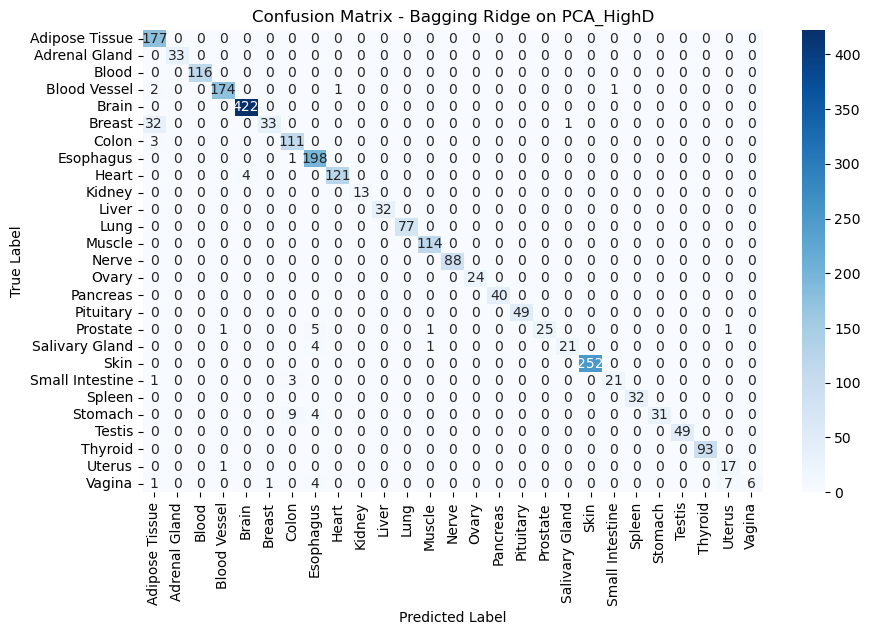

In [18]:
# visualize results
plt.figure(figsize=(10, 6))
sns.heatmap(
    pd.crosstab(best_results['y_test'], best_results['y_pred']),
    annot=True, fmt='d', cmap='Blues'
)
plt.title(f'Confusion Matrix - {overall_best[0]} on {overall_best[1]}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

***Overall, the models (bagging ridge and AdaBoost) did not have notable performance when tasked with predicting tissue of origin from gene expression latent space representations. The accuracy for all models (except Bagging ridge on high D PCA) was no better than chance. Bagging ridge fit to the high dimensional PCA (retained 85% variance) gene expression data performed dramatically better than the other models, with an accuracy of 96.38% and weighted precision, recall, and F1 scores of 0.97, 0.96, and 0.96, respectivley.***